In [ ]:
!pip install ranx

In [ ]:
!wget -O trec-pm.tar.xz https://th-koeln.sciebo.de/s/JTTV4fxFmuCGMeY/download
!tar -xf trec-pm.tar.xz

In [ ]:
!wget -O bibliometric.tar.xz https://th-koeln.sciebo.de/s/BRolGxMzrCipoTT/download
!tar -xf bibliometric.tar.xz

In [8]:
import os
import random
import gzip
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style('darkgrid')
from ranx import Qrels, Run, evaluate, compare, fuse, optimize_fusion
from random import randint

In [20]:
DIR_IN = 'trec-pm/trec-pm-2017-abstracts' 
DIR_RUN = 'runs/trec-pm-2017-abstracts'    
PATH_QRELS = "trec-pm/trec-pm-2017-abstracts/qrels-final-abstracts.txt"
DIR_CSV = 'experimental_results/trec-pm-2017-abstracts/'
YEAR = 2017

# DIR_IN = 'trec-pm/trec-pm-2018-abstracts' 
# DIR_RUN = 'runs/trec-pm-2018-abstracts'    
# PATH_QRELS = "trec-pm/trec-pm-2018-abstracts/qrels-treceval-abstracts-2018-v2.txt"
# DIR_CSV = 'experimental_results/trec-pm-2018-abstracts/'
# YEAR = 2018

# DIR_IN = 'trec-pm/trec-pm-2019-abstracts' 
# DIR_RUN = 'runs/trec-pm-2019-abstracts'    
# PATH_QRELS = "trec-pm/trec-pm-2019-abstracts/qrels-treceval-abstracts.2019.txt"
# DIR_CSV = 'experimental_results/trec-pm-2019-abstracts/'
# YEAR = 2019

In [4]:
def extract_runs(dir_in, dir_out):

    os.makedirs(dir_out, exist_ok=True)

    for root, dirs, files in os.walk(dir_in):
        for file in files:
            if file.endswith(".gz"):
                run_name = file.split('.')[1]
                with gzip.open(os.path.join(root, file), 'rb') as f_in:
                    file_content = f_in.read()
                    file_out = dir_out + '/' + run_name
                    with open(file_out, 'wb') as f_out:
                        f_out.write(file_content) 
                        if YEAR == 2019:
                            !cat $file_out | cut -d" " -f1 > tmp; mv tmp $file_out
                            
extract_runs(DIR_IN, DIR_RUN)

In [10]:
def get_run(category, year=2017):
    
    run_names = {'TC': 'Citations (C)',
                 'ATTENTION_SCORE': 'Altmetrics (A)',
                 'RL': 'Research level (R)',
                 'IF': 'Impact factor (I)',
                 'PY': 'Publication year (P)'}
    
    
    df = pd.read_csv('STI_Ergebnisse_final.txt', sep='\t', low_memory=False)
    _run = Run(name=run_names[category])
    
    _df = df[df[category].notna()]
    _df = _df[_df['TOPIC'].str.contains(str(year), regex=False)]
    _df = _df[['TOPIC','PUBMED_ID', category]]
    
    if category in ['IF', 'RL']:
        _df[category] = _df[category].str.replace(',','.').astype(float)

    for row in _df.iterrows():
        topic = row[1]['TOPIC'].split('-')[1]
        pubmed_id = row[1]['PUBMED_ID']
        cnt = row[1][category]

        if cnt > 0:
            _run.add_score(str(topic), str(pubmed_id), float(cnt))
    
    return _run

def get_random_run(qrels):
    _run = Run(name='random')
    
    for topic, _qrels in dict(qrels).items():
        for pubmed_id, label in _qrels.items():
            _run.add_score(str(topic), str(pubmed_id), randint(1,10000))
    
    return _run

## RQ1: To what extent can bibliometric relevance signals be used as ranking criteria for TREC Precision Medicine?

In [90]:
qrels = Qrels.from_file(PATH_QRELS, kind="trec")

run_cite = get_run('TC', year=YEAR) # get run based on citations
run_alt = get_run('ATTENTION_SCORE', year=YEAR) # get run based on attention score
run_py = get_run('PY', year=YEAR) 
run_rl = get_run('RL', year=YEAR) 
run_if = get_run('IF', year=YEAR) 

report = compare(
    qrels=qrels,
    runs=[run_cite, run_alt, run_py, run_rl, run_if],
    metrics=["recall", "ndcg", "map", "precision@10", "bpref", "mrr"],
    rounding_digits=4,
    max_p=0.05
)

print(report)
print(report.to_latex())

#    Model                 Recall      NDCG       MAP        P@10     BPref       MRR
---  --------------------  ----------  ---------  ---------  -------  -------  ------
a    Citations (C)         0.7853ᵇᵈᵉ   0.4992ᵇᵈᵉ  0.1812ᵇᵈᵉ  0.2700ᵈ  0.1577ᵈ  0.3924
b    Altmetrics (A)        0.4162      0.3163     0.1020     0.2400ᵈ  0.1434   0.382
c    Publication year (P)  0.7972ᵃᵇᵈᵉ  0.5069ᵇᵈᵉ  0.1733ᵇᵈᵉ  0.2033ᵈ  0.1541ᵈ  0.3739
d    Research level (R)    0.7608ᵇᵉ    0.4666ᵇᵉ   0.1546ᵇᵉ   0.1200   0.1307   0.2461
e    Impact factor (I)     0.6301ᵇ     0.4162ᵇ    0.1399ᵇ    0.2500ᵈ  0.1444   0.3815
% Add in preamble
\usepackage{graphicx}
\usepackage{booktabs}


% To change the table size, act on the resizebox argument `0.8`.
\begin{table*}[ht]
\centering
\caption{
Overall effectiveness of the models.
The best results are highlighted in boldface.
Superscripts denote significant differences in paired Student's t-test with $p \le 0.05$.
}
\resizebox{0.8\textwidth}{!}{
\begin{tabular}{c|l|c|c|c

Random ranking based on qrels

In [ ]:
_df_data = []
cnt = 0
trials = 10
while cnt < trials:
    run_random = get_random_run(qrels) 
    _df_data.append(evaluate(qrels, run_random,["recall", "ndcg", "map", "precision@10", "bpref", "mrr"]))
    cnt += 1
df = pd.DataFrame(_df_data)
print(df.mean().to_latex())

### RBP comparison

In [55]:
report = compare(
    qrels=qrels,
    runs=[run_cite, run_alt, run_py, run_rl, run_if],
    metrics=["rbp.95", "rbp.9", "rbp.85", "rbp.8", "rbp.75"],
    rounding_digits=4,
    max_p=0.05 
)

print(report)
# print(report.to_latex())

#    Model                 RBP.95    RBP.9    RBP.85      RBP.8    RBP.75
---  --------------------  --------  -------  --------  -------  --------
a    Citations (C)         0.2507ᵈ   0.2595ᵈ  0.2611     0.2603    0.2593
b    Altmetrics (A)        0.2369ᵈ   0.2388ᵈ  0.2367ᵈ    0.2331    0.2291
c    Publication year (P)  0.2144ᵈ   0.2128   0.2113     0.2114    0.213
d    Research level (R)    0.1542    0.1410   0.1336     0.1292    0.1265
e    Impact factor (I)     0.2272    0.2355   0.2389     0.2397    0.239


### nDCG comparison

In [56]:
report = compare(
    qrels=qrels,
    runs=[run_cite, run_alt, run_py, run_rl, run_if],
    metrics=["ndcg@1", "ndcg@5", "ndcg@10", "ndcg@100", "ndcg@1000"],
    rounding_digits=4,
    max_p=0.05  
)

print(report)
# print(report.to_latex())

#    Model                   NDCG@1  NDCG@5    NDCG@10    NDCG@100    NDCG@1000
---  --------------------  --------  --------  ---------  ----------  -----------
a    Citations (C)           0.1333  0.1759    0.1969     0.2225ᵈ     0.4992ᵇᵈᵉ
b    Altmetrics (A)          0.1833  0.1978ᵈ   0.1935ᵈ    0.2317ᵈ     0.3163
c    Publication year (P)    0.2333  0.1811    0.1745     0.2224ᵈ     0.5069ᵇᵈᵉ
d    Research level (R)      0.05    0.0845    0.0839     0.1612      0.4666ᵇᵉ
e    Impact factor (I)       0.1833  0.1811    0.1864ᵈ    0.2076      0.4162ᵇ


### Different rank fusions of bibliometric data.

In [57]:
fuse_method = 'rrf'

fused_runs = []

run_dict = {'C': run_cite,
            'A': run_alt,
            'P': run_py,
            'R': run_rl,
            'I': run_if}

# https://stackoverflow.com/questions/464864/how-to-get-all-possible-combinations-of-a-list-s-elements
import itertools

# run_codes = ['a', 'b', 'c', 'd', 'e']
run_codes = list(run_dict.keys())

for L in range(len(run_codes) + 1):
    for subset in itertools.combinations(run_codes, L):
        if len(subset) > 1:
            
            run_name = ''.join(list(subset))
            comb = [run_dict.get(code) for code in subset]
            run_fuse = fuse(runs=comb, method=fuse_method)
            run_fuse.name = run_name
            fused_runs.append(run_fuse)
                 
# runs = [run_cite, run_alt, run_rl, run_if, run_py, run_random] + fused_runs
  
report = compare(
    qrels=qrels,
    runs=fused_runs,
    metrics=["ndcg", "map", "precision@10", "bpref", "mrr"],
    rounding_digits=4,
    max_p=0.05 
)

print(report)
print(report.to_latex())

#    Model    NDCG               MAP              P@10  BPref        MRR
---  -------  -----------------  -------------  ------  --------  ------
a    CA       0.5256ᵈᵍʲᵖ         0.1917ᵍʲ       0.27    0.1674    0.5069
b    CP       0.5217ᵍʲ           0.1919ʲᵗ       0.2733  0.1695ʲ   0.5179
c    CR       0.4967ʲ            0.1721         0.2067  0.1459    0.4162
d    CI       0.5034ʲ            0.1784         0.2767  0.1538    0.4278
e    AP       0.5299ᵍʰʲᵗ         0.1880         0.2533  0.1698    0.4874
f    AR       0.5061ʲ            0.1743ʲ        0.2267  0.1513    0.402
g    AI       0.4872             0.1712         0.2967  0.1589    0.4977
h    PR       0.4978ʲ            0.1677         0.22    0.1425    0.3201
i    PI       0.5157ᵍʲ           0.1795         0.2767  0.1563    0.5062
j    RI       0.4755             0.1587         0.2     0.1350    0.4064
k    CAP      0.5374ᶜᵈᶠᵍʰʲᵒᵖˢᵗˣ  0.1977ᶠᵍʲˢᵗ    0.2867  0.1749ᶠʲ  0.5511
l    CAR      0.5189ᶜᵍʲᵖˣ        0.1848ʲᵖ       0.25

## RQ2: Can bibliometric-enhanced rank fusion methods improve the overall retrieval performance?

In [456]:
fuse_method = "rrf"

df_data = []

for root, dirs, files in os.walk(DIR_RUN):
    for file in files:
        run = Run.from_file(os.path.join(root, file), kind="trec")
        
        run_rrf = fuse(runs=[run, run_cite, run_alt, run_py], method=fuse_method)

        report = compare(
            qrels=qrels,
            runs=[run, run_rrf],
            metrics=["ndcg", "map", "precision@10", "bpref", "mrr", 
                     "ndcg@10", "ndcg@50", "ndcg@100", "ndcg@200", "ndcg@500", "ndcg@1000"],
            max_p=0.05  
        )

        report_dict = report.to_dict()
        metrics = report_dict.get('metrics')
        base_name = report_dict.get('model_names')[0]
        base_scores = report_dict.get(base_name).get('scores')
        fuse_scores = report_dict.get(fuse_method).get('scores')
        base_pval = report_dict.get(base_name).get('comparisons').get(fuse_method)

        _eval = {'run': base_name}

        for metric in metrics:
            _eval[metric + ' (base)'] = base_scores.get(metric)
            _eval[metric + ' (fuse)'] = fuse_scores.get(metric)
            _eval[metric + ' (diff)'] = fuse_scores.get(metric) - base_scores.get(metric)
            _eval[metric + ' (pval)'] = base_pval.get(metric)
            
        df_data.append(_eval)
        
df = pd.DataFrame(df_data)

os.makedirs(DIR_CSV, exist_ok=True)
file_out = DIR_CSV + fuse_method + '.csv'
df.to_csv(file_out)

### nDCG analysis

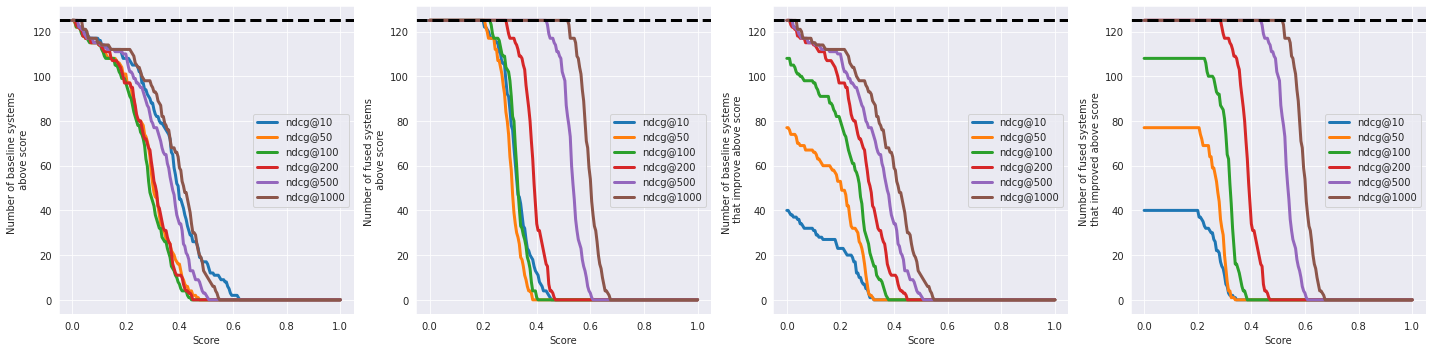

In [93]:
df = pd.read_csv('experimental_results/trec-pm-2017-abstracts/rrf.csv')

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5))

df_data = {}
for measure in [ 'ndcg@10', 'ndcg@50', 'ndcg@100', 'ndcg@200', 'ndcg@500', 'ndcg@1000']:
    _data = {}
    for thresh in [round(0.005*i, 3) for i in range(0,201)]:
        _data[thresh] = len(df[(df[measure +' (base)'] > thresh)])
    df_data[measure] = _data
_df = pd.DataFrame.from_dict(df_data)
_df.plot(linewidth=3, xlabel='Score', ylabel='Number of baseline systems \n above score', ax=axes[0])
axes[0].axhline(y = len(df), color='black',linestyle = '--', linewidth=3)

df_data = {}
for measure in ['ndcg@10', 'ndcg@50', 'ndcg@100', 'ndcg@200', 'ndcg@500', 'ndcg@1000']:
    _data = {}
    for thresh in [round(0.005*i, 3) for i in range(0,201)]:
        _data[thresh] = len(df[(df[measure +' (fuse)'] > thresh)])
    df_data[measure] = _data
_df = pd.DataFrame.from_dict(df_data)
_df.plot(linewidth=3, xlabel='Score', ylabel='Number of fused systems \n above score', ax=axes[1])
axes[1].axhline(y = len(df), color='black',linestyle = '--', linewidth=3)

df_data = {}
for measure in [ 'ndcg@10', 'ndcg@50', 'ndcg@100', 'ndcg@200', 'ndcg@500', 'ndcg@1000']:
    _data = {}
    for thresh in [round(0.005*i, 3) for i in range(0,201)]:
        _data[thresh] = len(df[(df[measure +' (base)'] > thresh) & (df[measure +' (diff)'] > 0)])
    df_data[measure] = _data
_df = pd.DataFrame.from_dict(df_data)
_df.plot(linewidth=3, xlabel='Score', ylabel='Number of baseline systems \n that improve above score', ax=axes[2])
axes[2].axhline(y = len(df), color='black',linestyle = '--', linewidth=3)

df_data = {}
for measure in [ 'ndcg@10', 'ndcg@50', 'ndcg@100', 'ndcg@200', 'ndcg@500', 'ndcg@1000']:
    _data = {}
    for thresh in [round(0.005*i, 3) for i in range(0,201)]:
        _data[thresh] = len(df[(df[measure +' (fuse)'] > thresh) & (df[measure +' (diff)'] > 0)])
    df_data[measure] = _data
_df = pd.DataFrame.from_dict(df_data)
_df.plot(linewidth=3, xlabel='Score', ylabel='Number of fused systems \n that improved above score', ax=axes[3])
axes[3].axhline(y = len(df), color='black',linestyle = '--', linewidth=3)

plt.tight_layout()
plt.savefig('figures/trec-pm-2017-abstracts/ndcg.rrf.pdf', bbox_inches='tight')

# TREC PM 2017 - Abstracts

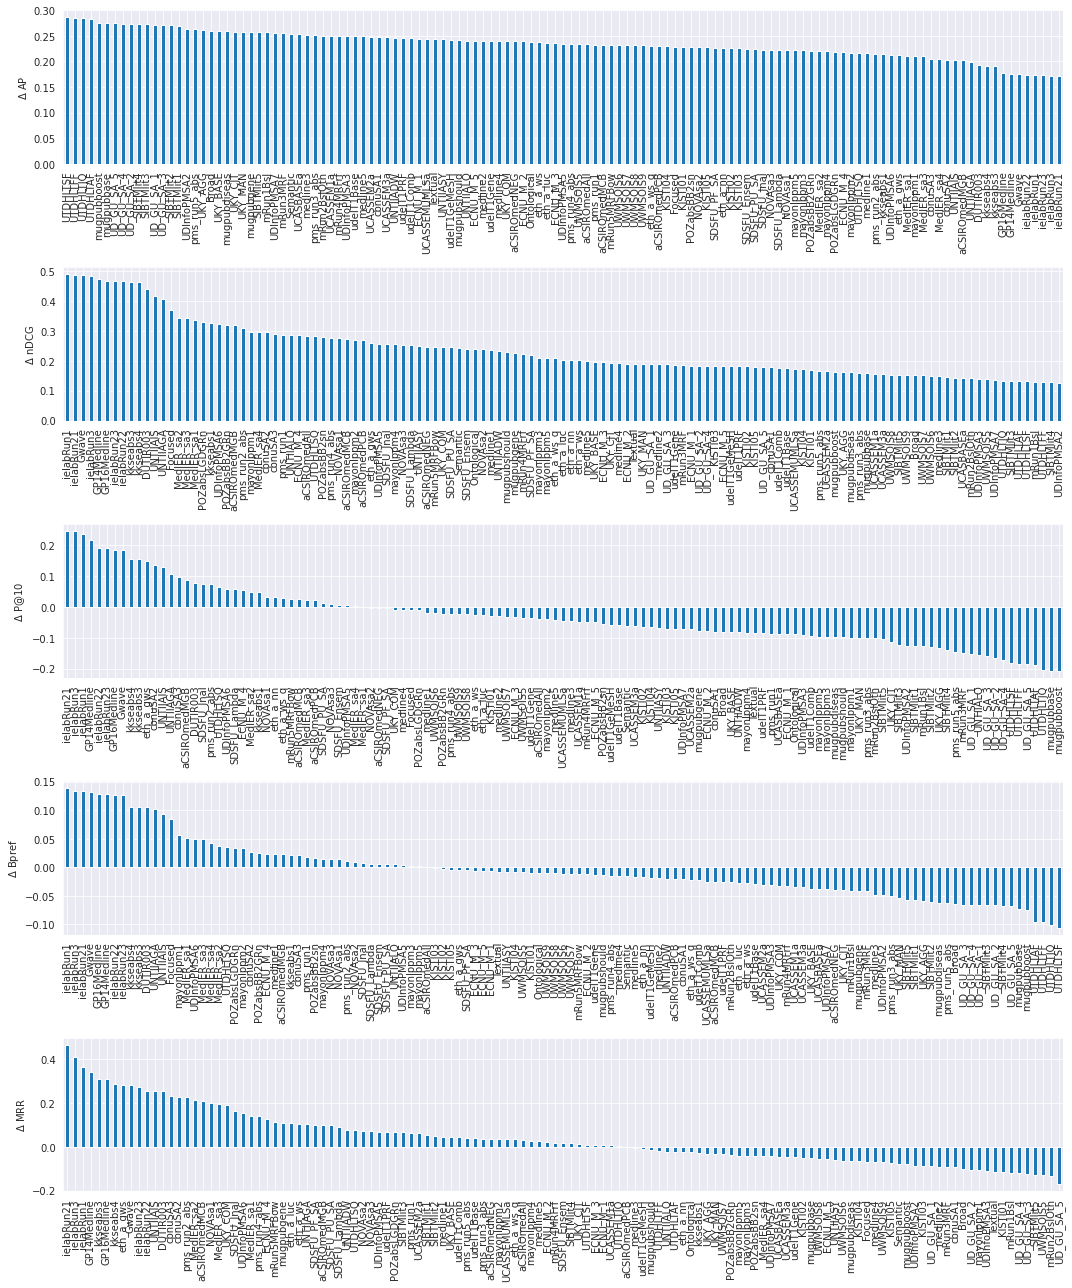

In [94]:
df = pd.read_csv('experimental_results/trec-pm-2017-abstracts/rrf.csv')
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15,18))
df.sort_values(by=['map (fuse)'], ascending=False).plot.bar(x='run', y='map (fuse)', ylabel=r'$\Delta$ AP', xlabel='', legend=False, ax=axes[0])
df.sort_values(by=['ndcg (diff)'], ascending=False).plot.bar(x='run', y='ndcg (diff)', ylabel=r'$\Delta$ nDCG', xlabel='', legend=False, ax=axes[1])
df.sort_values(by=['precision@10 (diff)'], ascending=False).plot.bar(x='run', y='precision@10 (diff)', ylabel=r'$\Delta$ P@10', xlabel='', legend=False, ax=axes[2])
df.sort_values(by=['bpref (diff)'], ascending=False).plot.bar(x='run', y='bpref (diff)', ylabel=r'$\Delta$ Bpref', xlabel='', legend=False, ax=axes[3])
df.sort_values(by=['mrr (diff)'], ascending=False).plot.bar(x='run', y='mrr (diff)', ylabel=r'$\Delta$ MRR', xlabel='', legend=False, ax=axes[4])
plt.tight_layout()
plt.savefig('figures/trec-pm-2017-abstracts/delta.rrf.pdf', bbox_inches='tight')

# TREC PM 2018 - Abstracts

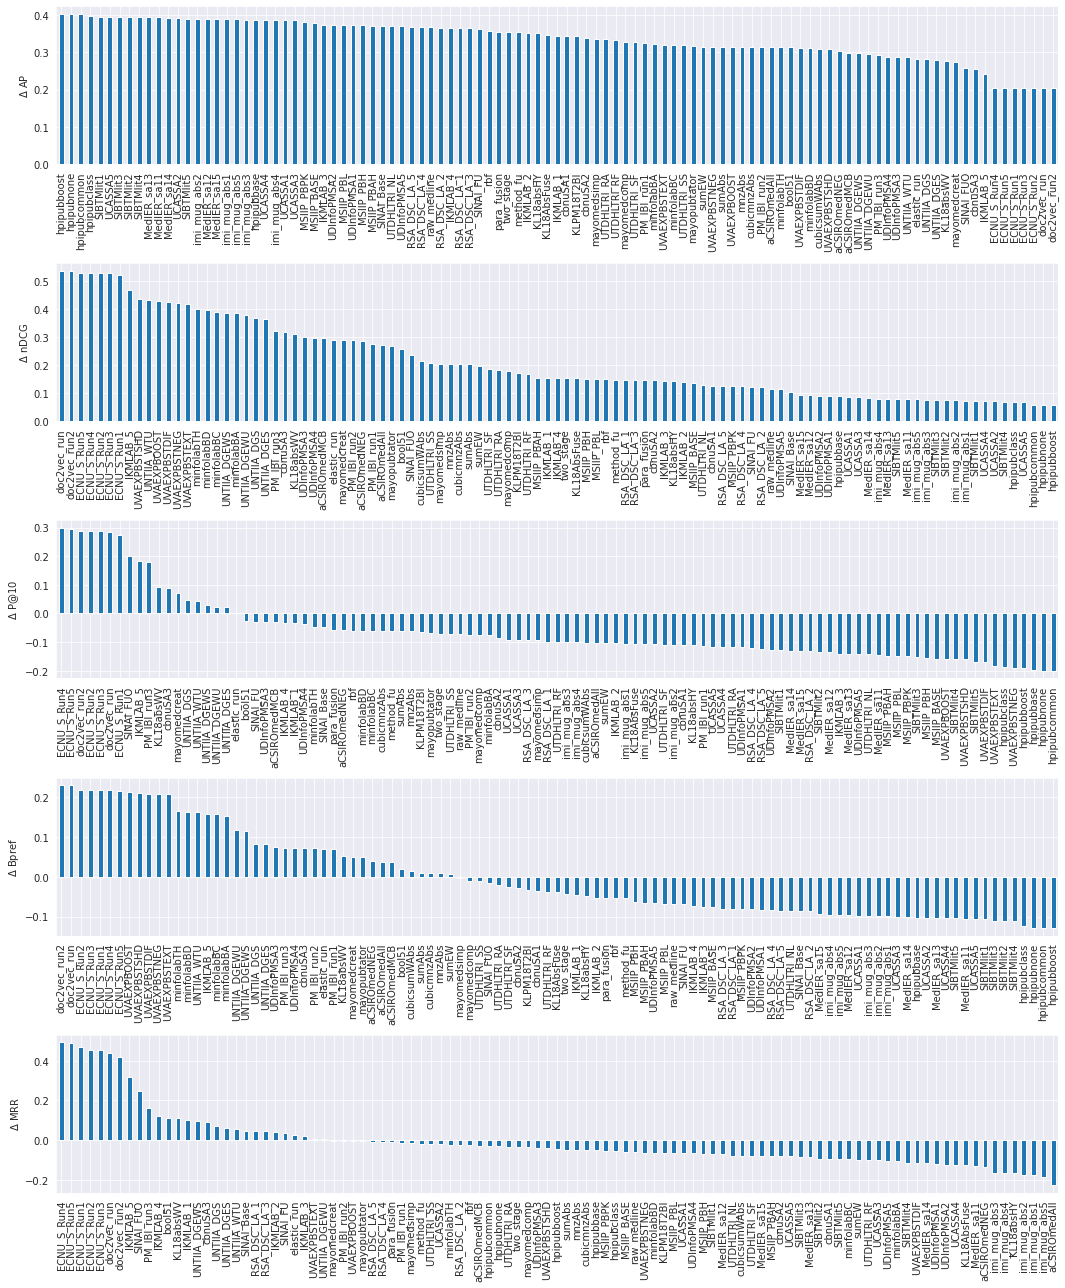

In [97]:
df = pd.read_csv('experimental_results/trec-pm-2018-abstracts/rrf.csv')
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15,18))
df.sort_values(by=['map (fuse)'], ascending=False).plot.bar(x='run', y='map (fuse)', ylabel=r'$\Delta$ AP', xlabel='', legend=False, ax=axes[0])
df.sort_values(by=['ndcg (diff)'], ascending=False).plot.bar(x='run', y='ndcg (diff)', ylabel=r'$\Delta$ nDCG', xlabel='', legend=False, ax=axes[1])
df.sort_values(by=['precision@10 (diff)'], ascending=False).plot.bar(x='run', y='precision@10 (diff)', ylabel=r'$\Delta$ P@10', xlabel='', legend=False, ax=axes[2])
df.sort_values(by=['bpref (diff)'], ascending=False).plot.bar(x='run', y='bpref (diff)', ylabel=r'$\Delta$ Bpref', xlabel='', legend=False, ax=axes[3])
df.sort_values(by=['mrr (diff)'], ascending=False).plot.bar(x='run', y='mrr (diff)', ylabel=r'$\Delta$ MRR', xlabel='', legend=False, ax=axes[4])
plt.tight_layout()
plt.savefig('figures/trec-pm-2018-abstracts/delta.rrf.pdf',bbox_inches='tight')

# TREC PM 2019 - Abstracts

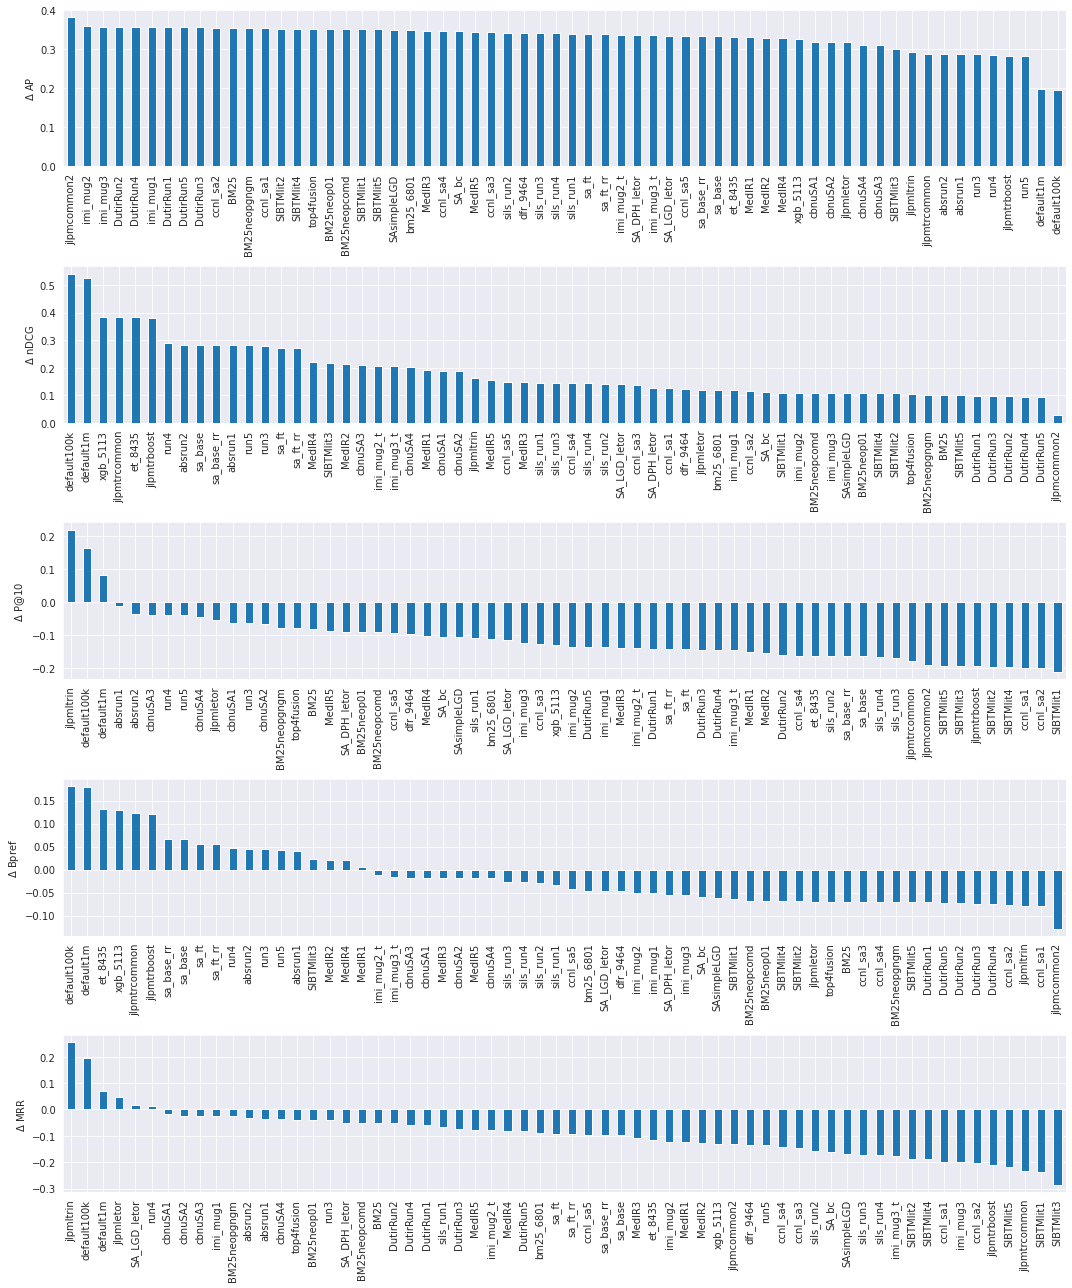

In [98]:
df = pd.read_csv('experimental_results/trec-pm-2019-abstracts/rrf.csv')
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15,18))
df.sort_values(by=['map (fuse)'], ascending=False).plot.bar(x='run', y='map (fuse)', ylabel=r'$\Delta$ AP', xlabel='', legend=False, ax=axes[0])
df.sort_values(by=['ndcg (diff)'], ascending=False).plot.bar(x='run', y='ndcg (diff)', ylabel=r'$\Delta$ nDCG', xlabel='', legend=False, ax=axes[1])
df.sort_values(by=['precision@10 (diff)'], ascending=False).plot.bar(x='run', y='precision@10 (diff)', ylabel=r'$\Delta$ P@10', xlabel='', legend=False, ax=axes[2])
df.sort_values(by=['bpref (diff)'], ascending=False).plot.bar(x='run', y='bpref (diff)', ylabel=r'$\Delta$ Bpref', xlabel='', legend=False, ax=axes[3])
df.sort_values(by=['mrr (diff)'], ascending=False).plot.bar(x='run', y='mrr (diff)', ylabel=r'$\Delta$ MRR', xlabel='', legend=False, ax=axes[4])
plt.tight_layout()
plt.savefig('figures/trec-pm-2019-abstracts/delta.rrf.pdf',bbox_inches='tight')

# Optimized Fusion Methods

see also: https://amenra.github.io/ranx/fusion/

In [23]:
### selection ###

fuse_method = "rbc"
fuse_dict_key = fuse_method

# fuse_method = "bayesfuse"
# fuse_dict_key = fuse_method

# fuse_method = "probfuse"
# fuse_dict_key = fuse_method

#### score-based methods ####

# fuse_method = ""
# fuse_dict_key = fuse_method

# fuse_method = ""
# fuse_dict_key = fuse_method

# fuse_method = ""
# fuse_dict_key = fuse_method

# fuse_method = ""
# fuse_dict_key = fuse_method

# fuse_method = ""
# fuse_dict_key = fuse_method

# fuse_method = ""
# fuse_dict_key = fuse_method

# fuse_method = "gmnz"
# fuse_dict_key = "comb_gmnz"

# fuse_method = ""
# fuse_dict_key = fuse_method

# fuse_method = ""
# fuse_dict_key = fuse_method

# fuse_method = ""
# fuse_dict_key = fuse_method

#### rank-based methods ####

# fuse_method = ""
# fuse_dict_key = fuse_method

# fuse_method = ""
# fuse_dict_key = fuse_method

# fuse_method = "logn_isr"
# fuse_dict_key = fuse_method

# fuse_method = "rbc"
# fuse_dict_key = fuse_method

# fuse_method = "rrf"
# fuse_dict_key = fuse_method

#### probabilistic methods ####

# fuse_method = "bayesfuse"
# fuse_dict_key = fuse_method

# fuse_method = "mapfuse"
# fuse_dict_key = fuse_method

# fuse_method = "posfuse"
# fuse_dict_key = fuse_method

# fuse_method = "probfuse"
# fuse_dict_key = fuse_method

# fuse_method = "segfuse"
# fuse_dict_key = fuse_method

# fuse_method = "slidefuse"
# fuse_dict_key = fuse_method

#### voting-based methods ####

# fuse_method = ""
# fuse_dict_key = fuse_method

# fuse_method = ""
# fuse_dict_key = fuse_method

# fuse_method = ""
# fuse_dict_key = fuse_method

# fuse_method = ""
# fuse_dict_key = fuse_method

if YEAR == 2017:
    samples = 5
    dir_train = 'runs/trec-pm-2018-abstracts/'
    train_runs = [Run.from_file(dir_train + random.choice(os.listdir(dir_train)), kind='trec') for i in range(0,samples)]
    train_qrels = Qrels.from_file('trec-pm/trec-pm-2018-abstracts/qrels-treceval-abstracts-2018-v2.txt', kind="trec")
    
if YEAR == 2018:
    samples = 5
    dir_train = 'runs/trec-pm-2019-abstracts/'
    train_runs = [Run.from_file(dir_train + random.choice(os.listdir(dir_train)), kind='trec') for i in range(0,samples)]
    train_qrels = Qrels.from_file('trec-pm/trec-pm-2019-abstracts/qrels-treceval-abstracts.2019.txt', kind="trec")

if YEAR == 2019:
    samples = 5
    dir_train = 'runs/trec-pm-2017-abstracts/'
    train_runs = [Run.from_file(dir_train + random.choice(os.listdir(dir_train)), kind='trec') for i in range(0,samples)]
    train_qrels = Qrels.from_file('trec-pm/trec-pm-2017-abstracts/qrels-final-abstracts.txt', kind="trec")

best_params = optimize_fusion(
    qrels=train_qrels,
    runs=train_runs,
    norm="min-max",
    method=fuse_method,
    metric="ndcg@100"
)

run_cite = get_run('TC', year=YEAR) # get run based on citations
run_alt = get_run('ATTENTION_SCORE', year=YEAR) # get run based on attention score
run_py = get_run('PY', year=YEAR) # get run based on publication year
qrels = Qrels.from_file(PATH_QRELS, kind="trec")

df_data = []

for root, dirs, files in os.walk(DIR_RUN):
    for file in files:
        run = Run.from_file(os.path.join(root, file), kind="trec")
        
        run_fuse = fuse(
            runs=[run, run_cite, run_alt, run_py],  
            norm="min-max",       
            method=fuse_method,        
            params=best_params,
        )

        report = compare(
            qrels=qrels,
            runs=[run, run_fuse],
            metrics=["ndcg", "map", "precision@10", "bpref", "mrr"],
            max_p=0.05  
        )

        report_dict = report.to_dict()
        metrics = report_dict.get('metrics')
        base_name = report_dict.get('model_names')[0]
        base_scores = report_dict.get(base_name).get('scores')
        fuse_scores = report_dict.get(fuse_dict_key).get('scores')
        base_pval = report_dict.get(base_name).get('comparisons').get(fuse_dict_key)

        _eval = {'run': base_name}

        for metric in metrics:
            _eval[metric + ' (base)'] = base_scores.get(metric)
            _eval[metric + ' (fuse)'] = fuse_scores.get(metric)
            _eval[metric + ' (diff)'] = fuse_scores.get(metric) - base_scores.get(metric)
            _eval[metric + ' (pval)'] = base_pval.get(metric)
            
        df_data.append(_eval)
        
df = pd.DataFrame(df_data)

os.makedirs(DIR_CSV, exist_ok=True)
file_out = DIR_CSV + fuse_method + '.csv'
df.to_csv(file_out)

Optimizing ProbFuse ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

## General statistics about how rank fusion changes the retrieval performance

In [25]:
def general_stats(method):
    data = {}
    for year in [2017, 2018, 2019]:
        
        path = 'experimental_results/trec-pm-' + str(year) + '-abstracts/' + method + '.csv'
        df = pd.read_csv(path)
        _data = {
            'Number of systems': len(df),
            'Improvements (nDCG)': len(df[df['ndcg (diff)'] > 0]),
            'Signif. improvements (nDCG)': len(df[(df['ndcg (pval)'] < 0.05) & (df['ndcg (diff)'] > 0)]),
            'Average improvement (nDCG)': df[(df['ndcg (pval)'] < 0.05) & (df['ndcg (diff)'] > 0)]['ndcg (diff)'].mean(),
            'Overall change (nDCG)': df['ndcg (diff)'].mean(),
            'Improvements (AP)': len(df[df['map (diff)'] > 0]),
            'Signif. improvements (AP)': len(df[(df['map (pval)'] < 0.05) & (df['map (diff)'] > 0)]),
            'Average improvement (AP)': df[(df['map (pval)'] < 0.05) & (df['map (diff)'] > 0)]['map (diff)'].mean(),
            'Overall change (AP)': df['map (diff)'].mean(),
            'Improvements (P@10)': len(df[df['precision@10 (diff)'] > 0]),
            'Signif. improvements (P@10)': len(df[(df['precision@10 (pval)'] < 0.05) & (df['precision@10 (diff)'] > 0)]),
            'Average improvement (P@10)': df[(df['precision@10 (pval)'] < 0.05) & (df['precision@10 (diff)'] > 0)]['precision@10 (diff)'].mean(),
            'Overall change (P@10)': df['precision@10 (diff)'].mean(),
            'Improvements (Bpref)': len(df[df['bpref (diff)'] > 0]),
            'Signif. improvements (Bpref)': len(df[(df['bpref (pval)'] < 0.05) & (df['bpref (diff)'] > 0)]),
            'Average improvement (Bpref)': df[(df['bpref (pval)'] < 0.05) & (df['bpref (diff)'] > 0)]['bpref (diff)'].mean(),
            'Overall change (Bpref)': df['bpref (diff)'].mean()
        }
        data[year] = _data

    return pd.DataFrame.from_dict(data).reindex(_data.keys())

RRF

In [26]:
general_stats('rrf')

,2017,2018,2019
Number of systems,125.000000,103.000000,62.000000
Improvements (nDCG),125.000000,103.000000,62.000000
Signif. improvements (nDCG),125.000000,103.000000,61.000000
Average improvement (nDCG),0.237820,0.216242,0.188202
Overall change (nDCG),0.237820,0.216242,0.185639
Improvements (AP),125.000000,103.000000,62.000000
Signif. improvements (AP),123.000000,103.000000,61.000000
Average improvement (AP),0.117309,0.143297,0.125433
Overall change (AP),0.116318,0.143297,0.124254
Improvements (P@10),37.000000,19.000000,3.000000


RBC

In [27]:
general_stats('rbc')

,2017,2018,2019
Number of systems,125.000000,103.000000,62.000000
Improvements (nDCG),125.000000,103.000000,62.000000
Signif. improvements (nDCG),125.000000,96.000000,61.000000
Average improvement (nDCG),0.182493,0.209240,0.173090
Overall change (nDCG),0.182493,0.197515,0.170316
Improvements (AP),115.000000,103.000000,62.000000
Signif. improvements (AP),81.000000,76.000000,43.000000
Average improvement (AP),0.073168,0.139388,0.115836
Overall change (AP),0.052731,0.110292,0.094461
Improvements (P@10),13.000000,15.000000,3.000000


BayesFuse

In [28]:
general_stats('bayesfuse')

,2017,2018,2019
Number of systems,125.000000,103.000000,62.000000
Improvements (nDCG),125.000000,103.000000,62.000000
Signif. improvements (nDCG),125.000000,103.000000,61.000000
Average improvement (nDCG),0.234122,0.233066,0.203578
Overall change (nDCG),0.234122,0.233066,0.200746
Improvements (AP),125.000000,103.000000,62.000000
Signif. improvements (AP),123.000000,103.000000,61.000000
Average improvement (AP),0.122005,0.175921,0.153528
Overall change (AP),0.120907,0.175921,0.152033
Improvements (P@10),43.000000,33.000000,6.000000


ProbFuse

In [29]:
general_stats('probfuse')

,2017,2018,2019
Number of systems,125.000000,103.000000,62.000000
Improvements (nDCG),125.000000,103.000000,62.000000
Signif. improvements (nDCG),125.000000,96.000000,61.000000
Average improvement (nDCG),0.171565,0.173825,0.167080
Overall change (nDCG),0.171565,0.164022,0.164669
Improvements (AP),113.000000,91.000000,62.000000
Signif. improvements (AP),80.000000,64.000000,48.000000
Average improvement (AP),0.051251,0.072348,0.081009
Overall change (AP),0.036759,0.047937,0.068966
Improvements (P@10),12.000000,12.000000,3.000000


In [46]:
df = general_stats('rrf')
df = pd.concat([df, general_stats('rbc').reindex(df.index)], axis=1)
df = pd.concat([df, general_stats('bayesfuse').reindex(df.index)], axis=1)
df = pd.concat([df, general_stats('probfuse').reindex(df.index)], axis=1)
df.loc['Number of systems'] = df.loc['Number of systems'].apply(int)

print(df.to_latex())

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
{} &        2017 &        2018 &       2019 &        2017 &        2018 &       2019 &        2017 &        2018 &       2019 &        2017 &        2018 &       2019 \\
\midrule
Number of systems            &  125.000000 &  103.000000 &  62.000000 &  125.000000 &  103.000000 &  62.000000 &  125.000000 &  103.000000 &  62.000000 &  125.000000 &  103.000000 &  62.000000 \\
Improvements (nDCG)          &  125.000000 &  103.000000 &  62.000000 &  125.000000 &  103.000000 &  62.000000 &  125.000000 &  103.000000 &  62.000000 &  125.000000 &  103.000000 &  62.000000 \\
Signif. improvements (nDCG)  &  125.000000 &  103.000000 &  61.000000 &  125.000000 &   96.000000 &  61.000000 &  125.000000 &  103.000000 &  61.000000 &  125.000000 &   96.000000 &  61.000000 \\
Average improvement (nDCG)   &    0.237820 &    0.216242 &   0.188202 &    0.182493 &    0.209240 &   0.173090 &    0.234122 &    0.233066 &   0.203578 &    0.171565 &    0.173825 &   0.167080 

## RQ3: How do users benefit from bibliometric-enhanced rank fusion results?

The RBP experiments show: the more patient the user, the higher benefit.

In [ ]:
fuse_method = "rrf"

_metrics = ['rbp.' + str(round(0.8 + 0.005*i, 3)).replace('0.', '') for i in range(0,40)]

df_data = []

for root, dirs, files in os.walk(DIR_RUN):
    for file in files:
        run = Run.from_file(os.path.join(root, file), kind="trec")
        
        run_rrf = fuse(runs=[run, run_cite, run_alt, run_py], method=fuse_method)

        report = compare(
            qrels=qrels,
            runs=[run, run_rrf],
            metrics=_metrics,
            max_p=0.05  
        )

        report_dict = report.to_dict()
        metrics = report_dict.get('metrics')
        base_name = report_dict.get('model_names')[0]
        base_scores = report_dict.get(base_name).get('scores')
        fuse_scores = report_dict.get(fuse_method).get('scores')
        base_pval = report_dict.get(base_name).get('comparisons').get(fuse_method)

        _eval = {'run': base_name}

        for metric in metrics:
            _eval[metric + ' (base)'] = base_scores.get(metric)
            _eval[metric + ' (fuse)'] = fuse_scores.get(metric)
            _eval[metric + ' (diff)'] = fuse_scores.get(metric) - base_scores.get(metric)
            _eval[metric + ' (pval)'] = base_pval.get(metric)
            
        df_data.append(_eval)
        
df = pd.DataFrame(df_data)

os.makedirs(DIR_CSV, exist_ok=True)
file_out = DIR_CSV + fuse_method + '.rbp.csv'
df.to_csv(file_out)

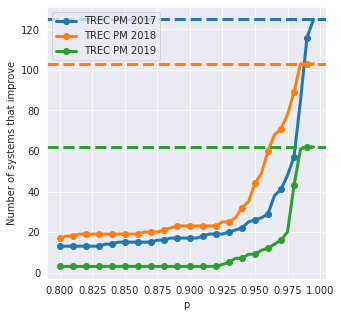

In [ ]:
df_2017 = pd.read_csv('experimental_results/trec-pm-2017-abstracts/rrf.rbp.csv')
df_2018 = pd.read_csv('experimental_results/trec-pm-2018-abstracts/rrf.rbp.csv')
df_2019 = pd.read_csv('experimental_results/trec-pm-2019-abstracts/rrf.rbp.csv')

_data_2017 = {}
_data_2018 = {}
_data_2019 = {}
_range = [round(0.8 + 0.005*i, 3) for i in range(0,40)]
for p in _range:
    _data_2017[p] = len(df_2017[df_2017['rbp.' + str(p).replace('0.', '') +' (diff)'] > 0])
    _data_2018[p] = len(df_2018[df_2018['rbp.' + str(p).replace('0.', '') +' (diff)'] > 0])
    _data_2019[p] = len(df_2019[df_2019['rbp.' + str(p).replace('0.', '') +' (diff)'] > 0])
pd.DataFrame.from_dict({'TREC PM 2017': _data_2017, 'TREC PM 2018': _data_2018, 'TREC PM 2019': _data_2019}).plot(xlabel='p', ylabel='Number of systems that improve', figsize=(5,5), marker='o', linewidth=3, markevery=2)
plt.axhline(y = len(df_2017), color='tab:blue',linestyle = '--', linewidth=3)
plt.axhline(y = len(df_2018), color='tab:orange',linestyle = '--', linewidth=3)
plt.axhline(y = len(df_2019), color='tab:green',linestyle = '--', linewidth=3)

plt.savefig('figures/rbp.rrf.pdf', bbox_inches='tight')